# Interpretability Notebook

This notebook is a demo notebook for developing and prototyping some interpretability ideas on rPPG models

In [1]:
import sys
sys.path.append("./code")

import pathlib
from aifc import Error
import os
from pathlib import Path
from glob import glob
import pickle

import h5py

from IPython.display import HTML

import matplotlib.pyplot as plt

import numpy as np

import scipy
from scipy import signal
from scipy.signal import butter

import tensorflow as tf

from inference_preprocess import preprocess_raw_video_, detrend
from model import CAN_3D,Hybrid_CAN
from pre_process import get_nframe_video, split_subj_, sort_video_list_, sort_dataFile_list_

import interp

There are two architectures available (CAN_3D and Hybrid_CAN) and you can select the same in the next code cell.
More information about these architectures can be found [here](https://papers.nips.cc/paper/2020/file/e1228be46de6a0234ac22ded31417bc7-Paper.pdf).

## Model and Data Setup

In [2]:
#Configuration for the model
img_rows = 36
img_cols = 36
frame_depth = 10
batch_size = 100

sm = 'hy'

if sm == "3d":
    model_name = "CAN_3D"
    model_checkpoint_3d = "./checkpoints/ppg-3d-can.h5"
    model = CAN_3D(frame_depth, 32, 64, (img_rows, img_cols, frame_depth, 3))
    model.load_weights(model_checkpoint_3d)
elif sm == "hy":
    model_name = "Hybrid_CAN"
    model_checkpoint_hy = "./checkpoints/ppg-hy-can.h5"
    model = Hybrid_CAN(frame_depth, 32, 64, (img_rows, img_cols, frame_depth, 3),
                        (img_rows, img_cols, 3))
    model.load_weights(model_checkpoint_hy)

print("Selected Model is:", model_name)

2023-05-24 11:05:06.011061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 11:05:06.027414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 11:05:06.031392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 11:05:06.035867: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Selected Model is: Hybrid_CAN


In [3]:
# model_checkpoint_hy = "./models/ppg-Hybrid_CAN-4-19/cv_0_epoch02_model.tf/"
# model_checkpoint_3d = "./models/ppg-CAN_3D-4-19/cv_0_epoch02_model.tf/"

#sample data path
data_path = "/data/rppg_22_bi_video_nt_lab/processed/p1/3/HREL_HIGH_dataFile.hdf5"

In [4]:
def prepare_3D_CAN(dXsub):
    frame_depth = 10
    num_window = int(dXsub.shape[0]) - frame_depth + 1
    tempX = np.array([dXsub[f:f + frame_depth, :, :, :] # (491, 10, 36, 36 ,6) (169, 10, 36, 36, 6)
                    for f in range(num_window)])
    tempX = np.swapaxes(tempX, 1, 3) # (169, 36, 36, 10, 6)
    tempX = np.swapaxes(tempX, 1, 2) # (169, 36, 36, 10, 6)
    return tempX

def prepare_Hybrid_CAN(dXsub):
    frame_depth = 10
    num_window = int(dXsub.shape[0]) - frame_depth + 1
    tempX = np.array([dXsub[f:f + frame_depth, :, :, :] # (169, 10, 36, 36, 6)
                        for f in range(num_window)])
    tempX = np.swapaxes(tempX, 1, 3) # (169, 36, 36, 10, 6)
    tempX = np.swapaxes(tempX, 1, 2) # (169, 36, 36, 10, 6)
    motion_data = tempX[:, :, :, :, :3]
    apperance_data = np.average(tempX[:, :, :, :, -3:], axis=-2)
    return motion_data, apperance_data

In [5]:
#load the processed data that is scaled and normalized
data = h5py.File(data_path, "r")
dXsub = np.array(data["data"])
dXsub_len = (dXsub.shape[0] // frame_depth) * frame_depth
dXsub = dXsub[:dXsub_len, :, :, :]
pulse_truth = np.array(data["pulse"])
data.close()
#FPS/sampling frequency of the ground truth data
fs = 25

In [6]:
data = h5py.File(data_path, "r")
d_in = np.array(data["data"])
d_in.shape

(1499, 36, 36, 6)

In [7]:
d_in2 = prepare_Hybrid_CAN(d_in)
d_in2[1].shape

(1490, 36, 36, 3)

In [8]:
# rPPG estimation of the processed video
if model_name == "CAN_3D":
    dXsub = prepare_3D_CAN(dXsub)
    dXsub_len = (dXsub.shape[0] // (frame_depth))  * (frame_depth)
    dXsub = dXsub[:dXsub_len, :, :, :,:]
    inputs = (dXsub[:, :, :,: , :3], dXsub[:, :, :, : , -3:])
    yptest = model.predict(inputs, verbose=1)
elif model_name == "Hybrid_CAN":
    dXsub1, dXsub2 = prepare_Hybrid_CAN(dXsub)
    dXsub_len1 = (dXsub1.shape[0] // (frame_depth*10))  * (frame_depth*10)
    dXsub1 = dXsub1[:dXsub_len1, :, :, :, :]
    dXsub_len2 = (dXsub2.shape[0] // (frame_depth*10))  * (frame_depth*10)
    dXsub2 = dXsub2[:dXsub_len2, :, :, :]
    inputs = (dXsub1, dXsub2)
    yptest = model.predict(inputs, verbose=1)
else:
    raise NotImplementedError
    
if model_name == "CAN_3D" or model_name == "Hybrid_CAN":
    pulse_pred = yptest[:,0]       
else:
    raise NotImplementedError
 

2023-05-24 11:05:10.283304: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8600


15/44 [=========>....................] - ETA: 0s  

2023-05-24 11:05:10.962459: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-24 11:05:11.103782: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


44/44 [==============================] - 2s 5ms/step


In [9]:
def HR_estimate(input_signal):
    '''Estimate the HR using the PSD of the rPPG signal'''
    #estimating HR from the predicted rPPG signal
    pulse_pred = detrend(np.cumsum(input_signal), 100)
    [b_pulse_pred, a_pulse_pred] = butter(1, [0.75 / fs * 2, 3.5 / fs * 2], btype='bandpass')
    pulse_pred = scipy.signal.filtfilt(b_pulse_pred, a_pulse_pred, np.double(pulse_pred))

    N = 30 * fs
    pulse_fft = np.expand_dims(pulse_pred, 0)
    f, pxx = signal.periodogram(pulse_fft, fs=fs, nfft=4 * N, detrend=False)
    fmask = np.argwhere((f >= 0.75) & (f <= 3.5))  # regular Heart beat are 0.75*60 and 2.5*60
    frange = np.take(f, fmask)
    HR = np.take(frange, np.argmax(np.take(pxx, fmask), 0))[0] * 60
    return HR


HR_pred = HR_estimate(pulse_pred)
HR_truth = HR_estimate(pulse_truth)

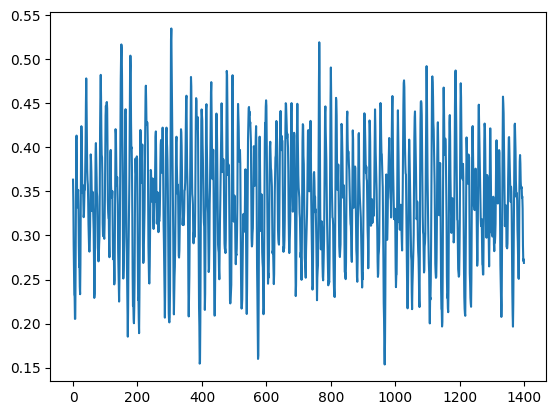

In [10]:
plt.plot(pulse_pred)

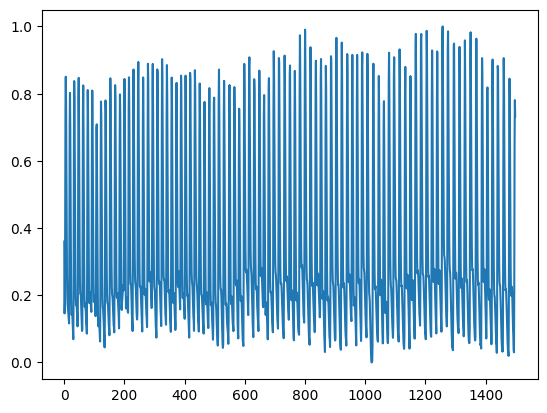

In [11]:
plt.plot(pulse_truth)

In [12]:
HR_truth, HR_pred

(86.0, 97.0)

## Interpretability Methods

In [13]:
# Print summary to find name of last 2D CNN layer
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 36, 36, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 36, 36, 32)   896         ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 34, 34, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 17, 17, 32)  0           ['conv2d_1[0][0]']               
 ing2D)                                                                                       

In [14]:
# setup variables 
last_conv_layer_name_app = 'conv2d_4'

fps = 24

diffs = inputs[0]
imgs = inputs[1]

# average image from input to appearance branch used for static visualizations
img = np.squeeze(np.mean(imgs, axis=0))
img = (img-np.min(img))/(np.max(img)-np.min(img)) #normalize to values between [0, 1] (but should check pre-processing normalization for true denormalization) also maybe should normalize each img before taking mean

### Gradient-weighted Regression Activation Maps

In [15]:
hms = interp.make_gradcam_heatmap(inputs, model, last_conv_layer_name_app)
hm_mean = np.mean(hms, axis=0) # aggregate all heatmaps for entire video

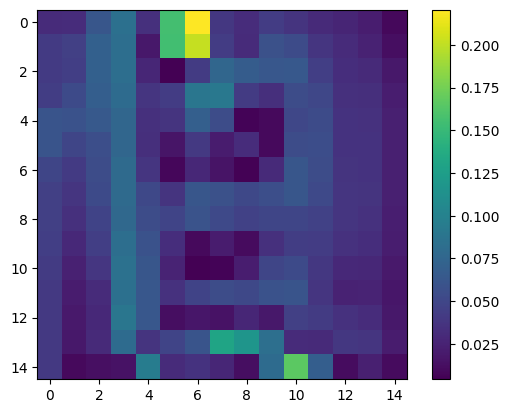

In [16]:
plt.imshow(np.squeeze(hm_mean))
plt.colorbar();

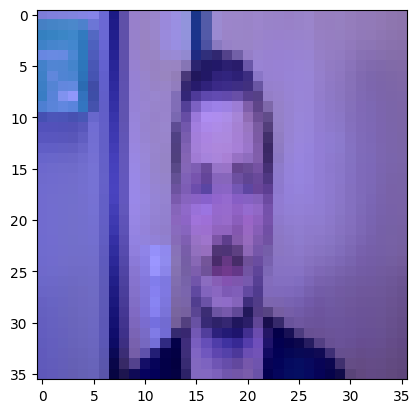

In [17]:
# get final output with interpolated activation values
gradcam = interp.superimpose(img, hm_mean, alpha=0.4)
plt.imshow(gradcam)

In [18]:
anim = interp.generate_animation(hms, imgs, fps, title='Gradient Weighted Activation Maps', alpha=0.4)
HTML(anim.to_html5_video())

### Attention Mask Visualizations

In [19]:
# setup model to get output of attention layers
attention_layers = ['attention_mask', 'attention_mask_1']
attn_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(l).output for l in attention_layers] + [model.output]
)

In [20]:
# get model outputs and attention maps
# for each input frame there is one activate map for each attention laye
attn0, attn1, preds = attn_model(inputs)

# normalize for visualization
attn0_norm = (attn0 - np.min(attn0)) / (np.max(attn0)-np.min(attn0))
attn1_norm = (attn1 - np.min(attn1)) / (np.max(attn1)-np.min(attn1))
attn0_norm.shape, attn1_norm.shape

(TensorShape([1400, 34, 34, 1]), TensorShape([1400, 15, 15, 1]))

In [21]:
# aggregate attention maps
attn0_mean = tf.reduce_mean(attn0, axis=(0, -1))
attn1_mean = tf.reduce_mean(attn1, axis=(0, -1))

# normalize to between 0 and 1
attn0_mean = (attn0_mean-np.min(attn0_mean))/(np.max(attn0_mean)-np.min(attn0_mean))
attn1_mean = (attn1_mean-np.min(attn1_mean))/(np.max(attn1_mean)-np.min(attn1_mean))

#### Attention Layer 1 Visualizations

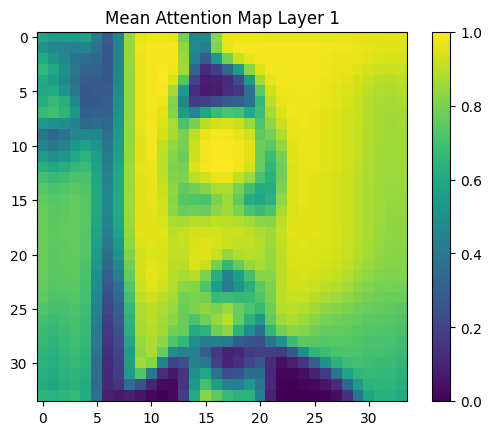

In [27]:
plt.imshow(attn0_mean)
plt.title('Mean Attention Map Layer 1')
plt.colorbar();

In [23]:
anim = interp.generate_animation(attn0_norm, imgs, fps, title='Attention Layer 1 Maps', alpha=0.4)
HTML(anim.to_html5_video())

#### Attention Layer 2 Visualizations

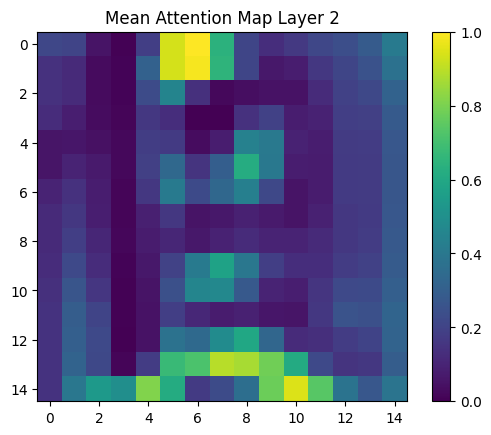

In [26]:
plt.imshow(attn1_mean)
plt.title('Mean Attention Map Layer 2')
plt.colorbar();

In [25]:
anim = interp.generate_animation(attn1_norm, imgs, fps, title='Attention Layer 2 Maps', alpha=0.4)
HTML(anim.to_html5_video())